# Notebook for Project 1

_Jonatan Haraldsson_ [jonhara@chalmers.se](mailto:jonhara@chalmers.se)

_Jesper Noord_ [noord@chalmers.se](mailto:noord@chalmers.se)



In [141]:
# relevant modules for this notebook
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import emcee
import corner
import scipy
from scipy.stats import gamma, invgamma, t, norm, norminvgauss, mode, uniform
import seaborn as sns
import random
import sklearn
import scipy.constants as const


# LaTeX font
plt.style.use('default')
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 16
plt.rcParams['font.size'] = font_size

c = const.speed_of_light *1e-3
G = const.gravitational_constant

np.random.seed(123)

## Importing the data from SCP 2.1 dataset and exploring data

In [142]:
data_ = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')
df = pd.DataFrame(data_[:,1:5])  # only keep z, mu, mu_err
df.columns = ["z", "mu", "mu_err", "unknown"]

df.head()

z = np.array(df['z'])
mu = np.array(df['mu'])
mu_err = np.array(df['mu_err'])

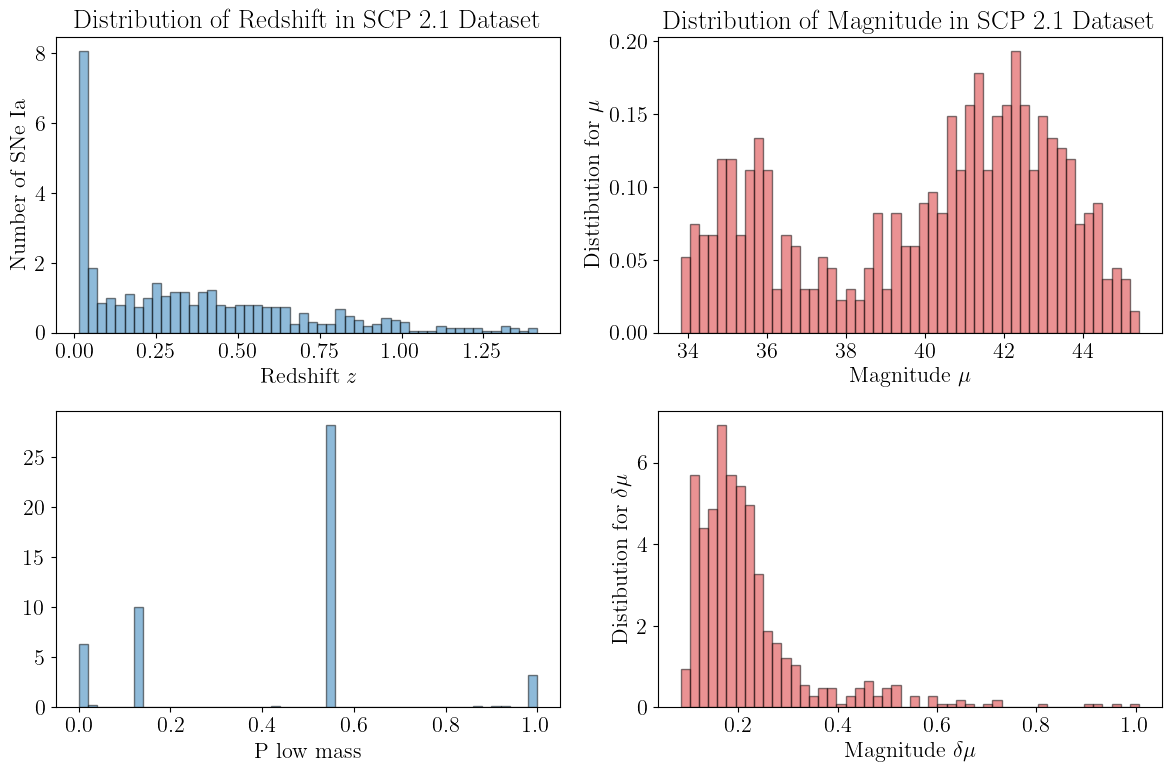

In [143]:
fig,ax = plt.subplots(2,2,figsize=(12,8))
ax[0,0].hist(z, bins=50,density=True,color='tab:blue',alpha=0.5,edgecolor='black')
ax[0,0].set_xlabel('Redshift $z$')
ax[0,0].set_ylabel('Number of SNe Ia')
ax[0,0].set_title('Distribution of Redshift in SCP 2.1 Dataset')
ax[0,1].hist(mu, bins=50,density=True,color='tab:red',alpha=0.5,edgecolor='black')
ax[0,1].set_xlabel('Magnitude $\\mu$')
ax[0,1].set_ylabel('Disttibution for $\\mu$')
ax[0,1].set_title('Distribution of Magnitude in SCP 2.1 Dataset')


ax[1,0].hist(df['unknown'], bins=50,density=True,color='tab:blue',alpha=0.5,edgecolor='black')
ax[1,0].set_xlabel('P low mass')
ax[1,1].hist(mu_err, bins=50,density=True,color='tab:red',alpha=0.5,edgecolor='black')
ax[1,1].set_xlabel('Magnitude $\\delta\\mu$')
ax[1,1].set_ylabel('Distibution for $\\delta\\mu$')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'All $z$ values')

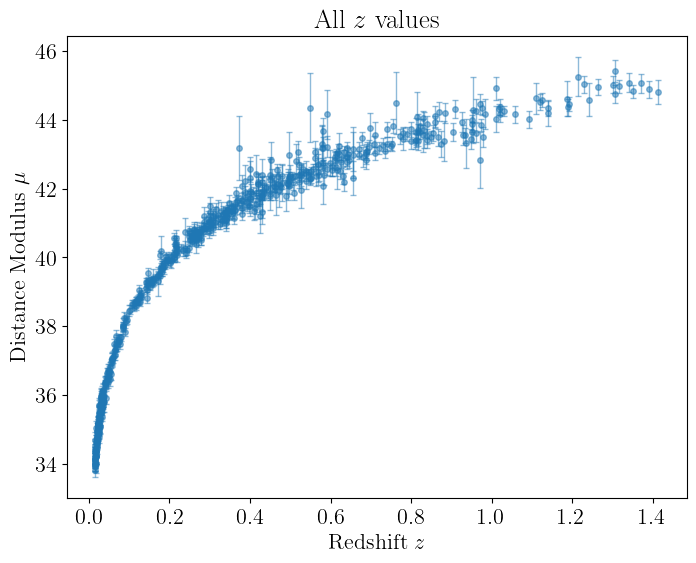

In [144]:
plt.figure(figsize=(8,6))
plt.errorbar(z,mu,yerr=mu_err,color='tab:blue',alpha=0.5,fmt='o',markersize=4,elinewidth=1,capsize=2)
plt.xlabel('Redshift $z$')
plt.ylabel('Distance Modulus $\\mu$')
plt.title('All $z$ values')

## Bayesian inference in small-$z$ regime

### Filtering small-$z$ regime

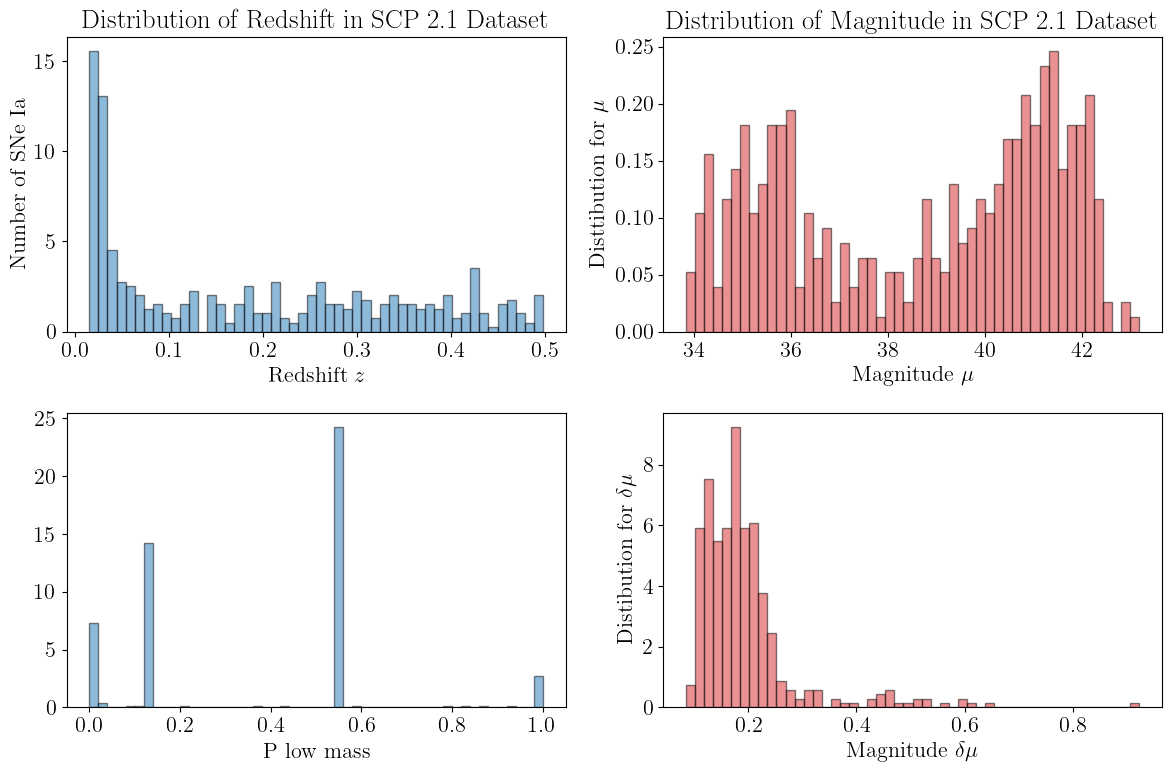

In [145]:
i = df['z'] < 0.5
z_low = np.array(df['z'][i])
mu_low = np.array(df['mu'][i])
mu_err_low = np.array(df['mu_err'][i])
unknown_low = np.array(df['unknown'][i])

fig,ax = plt.subplots(2,2,figsize=(12,8))
ax[0,0].hist(z_low, bins=50,density=True,color='tab:blue',alpha=0.5,edgecolor='black')
ax[0,0].set_xlabel('Redshift $z$')
ax[0,0].set_ylabel('Number of SNe Ia')
ax[0,0].set_title('Distribution of Redshift in SCP 2.1 Dataset')
ax[0,1].hist(mu_low, bins=50,density=True,color='tab:red',alpha=0.5,edgecolor='black')
ax[0,1].set_xlabel('Magnitude $\\mu$')
ax[0,1].set_ylabel('Disttibution for $\\mu$')
ax[0,1].set_title('Distribution of Magnitude in SCP 2.1 Dataset')


ax[1,0].hist(unknown_low, bins=50,density=True,color='tab:blue',alpha=0.5,edgecolor='black')
ax[1,0].set_xlabel('P low mass')
ax[1,1].hist(mu_err_low, bins=50,density=True,color='tab:red',alpha=0.5,edgecolor='black')
ax[1,1].set_xlabel('Magnitude $\\delta\\mu$')
ax[1,1].set_ylabel('Distibution for $\\delta\\mu$')

plt.tight_layout()
plt.show()

### Defining the model 

In [146]:
def d_to_mu(d):
    return 5 * np.log10(d) + 25

def get_dl(H_0,z,q_0):
    d = (c / H_0) * (z + (1-q_0) * z**2/2)
    return d

def low_z_model(H,z,q0):
    model = d_to_mu(get_dl(H,z,q0))
    return model

Text(0.5, 0, '$d_L$ [Mpc]')

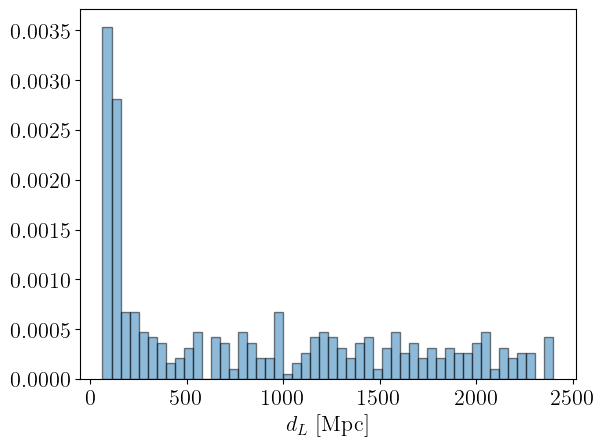

In [147]:
plt.hist(get_dl(70,z_low,0.5), bins=50,density=True,color='tab:blue',alpha=0.5,edgecolor='black')
plt.xlabel('$d_L$ [Mpc]')

### Defining distributions

Your first task is to use $$d_L=\frac{c}{H_0}\left(z + \frac{1}{2}(1-q_0)z^2\right)$$ in the small-$z$ regime $(z < 0.5)$ to extract a joint probability
distribution for $H_0$ and $q_0$. You should use data weights proportional to the measurement errors,
and an inverse gamma prior for the unknown error scale $σ^2$. You can use e.g. uniform priors for
$H0$ and $q0$ if you like.

#### $\log$-Prior, $\log$-Likelihood and $\log$-posterior 

Prior is given by $$\mathcal{U}_H[H_{min},H_{max}]\times\mathcal{U}_q[q_{min},q_{max}]\times \mathcal{IG}(\alpha,\beta,\sigma^2)$$

Likelihood's given by $$\cancel{\left( \frac{1}{2\pi} \right)^{N_d/2}} \frac{1}{|\Sigma_{\varepsilon}|^{1/2}} \exp \left[ -\frac{1}{2} (\mathcal{D} - \boldsymbol{y}_{model})^{T} \Sigma_{\varepsilon}^{-1} (\mathcal{D} - \boldsymbol{y}_{model}) \right],$$ where $$\Sigma_\varepsilon=\begin{bmatrix} \sigma^2_1 & \cdots       &        0 \\ \vdots&     \ddots   & 0  \\ 0      &        &      \sigma_n^2 \end{bmatrix}\quad\text{and}\quad\mathcal{D} = 10^{(\mu - 25)/5} \quad \text{and}\quad \boldsymbol{y}_{model}=\frac{c}{H_0}\left(z + \frac{1}{2}(1-q_0)z^2\right)$$

So the log-likelihood is then given by $$\left[ -\frac{1}{2} (\mathcal{D} - \boldsymbol{y}_{model})^{T} \Sigma_{\varepsilon}^{-1} (\mathcal{D} - \boldsymbol{y}_{model}) \right] - 0.5\det\{{\Sigma_\varepsilon}\}$$

In [148]:
def log_likelihood(theta, z, mu, mu_err):
    '''
    z - found in data frame
    mu - found in data frame
    sig_m - found in data frame
    '''

    Nd = len(mu)
    resid = mu - d_to_mu(get_dl(theta[0],z,theta[1]))
    W = 1.0 / (mu_err**2) * (1/Nd)
    quad = -1/2 * np.sum(resid**2 * W)/theta[2]
    const = -Nd/2 * np.sum(np.log(2 * np.pi * theta[2])) + 1/2 * np.sum(np.log(W))
    log_like = quad + const

    return log_like

def log_prior(theta,a0, b0, H0_lims = [50,100], q0_lims = [-2,2]):

    H0 = theta[0]
    q0  = theta[1]
    sig2 = theta[2]

    H0_min = H0_lims[0]; H0_max = H0_lims[1]
    q0_min = q0_lims[0];  q0_max = q0_lims[1]

    log_H = uniform.logpdf(H0, loc=H0_min, scale=H0_max - H0_min)

    log_q = uniform.logpdf(q0, loc = q0_min, scale = q0_max - q0_min)

    log_th = log_q + log_H

    log_IG = invgamma.logpdf(sig2,a=a0, scale=b0)  

    lp = log_th + log_IG
    
    return lp


def log_posterior(theta, z, mu, sig_m, a0, b0):

    log_like = log_likelihood(theta, z, mu, sig_m)
    log_pri = log_prior(theta, a0, b0)
    
    log_post = log_like + log_pri
    if np.isnan(log_post):
        return -np.inf
    
    return log_post

# helper function to convert the IG mean,mode to alpha,beta
def mean_mode_2_IG_alpha_beta(mean,mode):
    alpha = (mode + mean)/(mean-mode)
    beta = (2 * mode * mean)/(mean-mode)
    return alpha, beta

In [149]:
IG_mean = 10
IG_mode = 0.5
a0, b0  = mean_mode_2_IG_alpha_beta(IG_mean,IG_mode)

print(log_prior(np.array([70,0.5,0.05**2]),a0,b0))

-413.6285638603839


### MCMC sampling
Here we go again!! 

In [150]:
def samples_MCMC(q0_lims, H0_lims, post,x, y, sigma ,nwalkers, burninproc =10 , iterations = 10000):
    """
    Sets up an MCMC sampler with initial positions for the walkers.

    Args:
        theta_0_lims (list): Minimum and maximum boundary for starting position in theta0.
        theta_1_lims (list): Minimum and maximum boundary for starting position in theta1.
        x (array): Independent data.
        y (array): Dependent data.
        post (callable): Function to compute the log-posterior or log-likelihood.
        nwalkers (int): Number of MCMC walkers.

    Returns:
        sampler (emcee.EnsembleSampler): Initialized MCMC sampler object.
    """
    
    ndim = 3  # Since theta has three parameters: [intercept, slope,sigma]

    rng = np.random.default_rng(seed = 1337)


    q   = rng.uniform(q0_lims[0],q0_lims[1],size = nwalkers)
    H   = rng.uniform(H0_lims[0],H0_lims[1],size = nwalkers)
    sig = rng.uniform(0.1,10,size = nwalkers)

    p0 = np.vstack((q,H,sig)).T

    burnin = int(burninproc*iterations/100)

    # Set up the MCMC sampler with the log posterior function
    sampler_post = emcee.EnsembleSampler(nwalkers, ndim, post, args = (x, y, sigma, a0, b0))
    new_pos, prob, state = sampler_post.run_mcmc(p0, burnin, progress=True)

    run = sampler_post.run_mcmc(new_pos, iterations)#, progress=True)
    samples = sampler_post.get_chain(discard = burnin,flat = True)

    return samples

In [176]:

x = z_low
y = mu_low
sig = mu_err_low

H0_lims = [50,90]
q0_lims = [-2,2]

samples = samples_MCMC(H0_lims,q0_lims,log_posterior,x,y,
                                 sigma = sig,iterations=int(5e3),nwalkers=10)

  0%|          | 0/500 [00:00<?, ?it/s]

/var/folders/cc/g7htxfj57sq65d7g1185yzwr0000gn/T/ipykernel_47983/462466183.py:12: RuntimeWarning: invalid value encountered in log
  const = -Nd/2 * np.sum(np.log(2 * np.pi * theta[2])) + 1/2 * np.sum(np.log(W))
100%|██████████| 500/500 [00:00<00:00, 620.25it/s]



In [152]:
print('Number of samples',len(samples))

Number of samples 50000


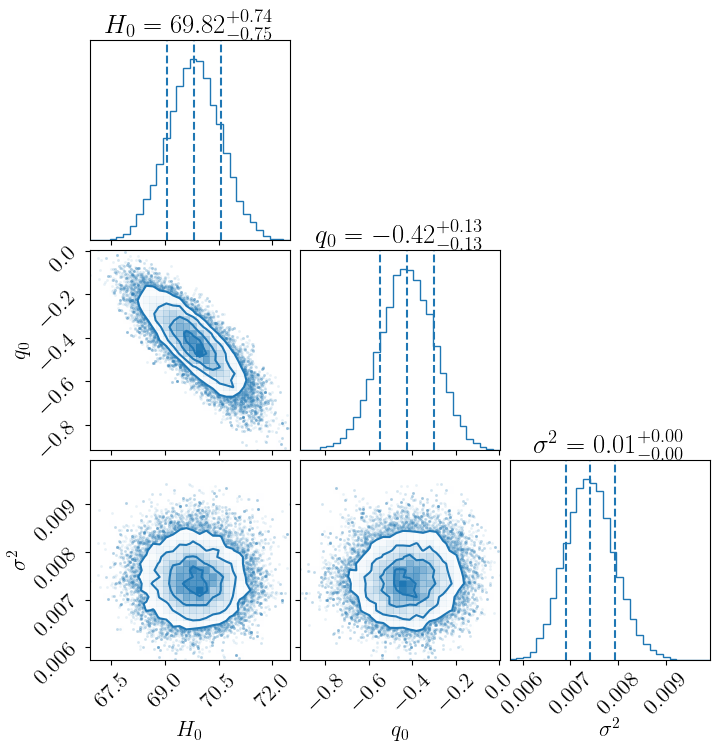

In [153]:
fig = corner.corner(samples, labels=[r"$H_0$", r"$q_0$",r"$\sigma^2$"], color='tab:blue',
                show_titles=True, bins=30, plot_contours=True, plot_datapoints=True, 
                plot_density=True,quantiles=[0.16,0.5,0.84])

# plt.savefig('figs/corner_H0_q0_sigma2.pdf')

<Figure size 1200x700 with 0 Axes>

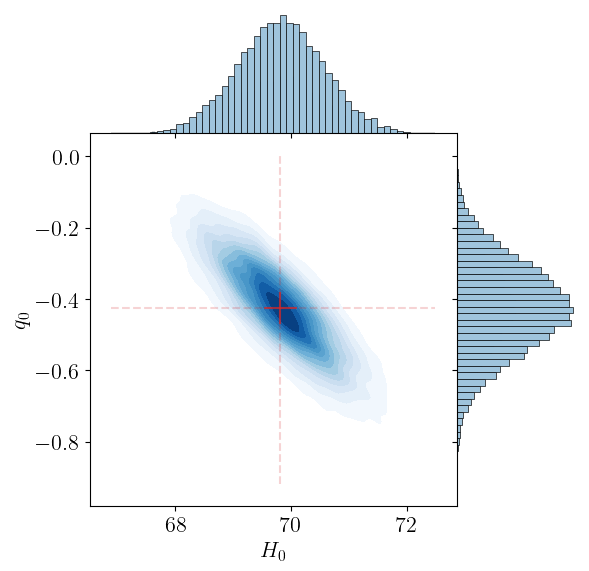

In [154]:
plt.figure(figsize=(12,7))
data = pd.DataFrame(samples,columns=['$H_0$','$q_0$','$\\sigma^2$'])
x = '$H_0$'; y = '$q_0$'
g = sns.jointplot(data = data, x =x,y =y,ratio=3,space = 0,kind = 'hist')#,joint_kws={'fill':True,'cmap':'Blues','levels':15})
for coll in list(g.ax_joint.collections):
    coll.remove()
g.plot_joint(sns.kdeplot,fill = True, cmap='Blues', levels = 15)
g.plot_marginals(sns.histplot, bins=50, color="#9FC4DC", alpha=1)

dy = 0.05 * (np.max(data[y]) - np.min(data[y]))
dx = 0.05 * (np.max(data[x]) - np.min(data[x]))
plt.vlines(np.mean(data[x]),np.mean(data[y])-dy,np.mean(data[y])+dy,color = 'tab:red',lw = 1.5,alpha = 0.7)
plt.vlines(np.mean(data[x]),np.min(data[y]),np.max(data[y]),color = 'tab:red',lw = 1.5,alpha = 0.2,ls = '--')
plt.hlines(np.mean(data[y]),np.mean(data[x])-dx,np.mean(data[x])+dx,color = 'tab:red',lw = 1.5,alpha = 0.7)
plt.hlines(np.mean(data[y]),np.min(data[x]),np.max(data[x]),color = 'tab:red',lw = 1.5,alpha = 0.2,ls = '--')
#plt.tight_layout()
#plt.savefig(f'figs/jointPDF_H0_q0.pdf')

In [155]:
print(f'Max H: {np.max(data[x])} \nMax q: {np.max(data[y])}')

Max H: 72.48715216846345 
Max q: 0.002387397603915653


In [156]:
def running_mean(x, factor=0.02):
    """
    Return the running mean of N element in a list.

    Args:
        x (ndarray): The list of elements,
        factor (float): The factor to multiply the length of the list by.
    
    Returns:
        ndarray: The running mean.
    """
    it, walker = x.shape
    N = int(factor * it)
    average = np.zeros((it - N+1,walker))

    for i in range(walker):
        cumsum = np.cumsum(np.insert(x[:,i], 0, 0))
        average[:,i] = ((cumsum[N:] - cumsum[:-N]) / float(N))

    return average


def trace_plotter(samples):
    ndim = samples.shape[1]
    fig, axes = plt.subplots(ndim, figsize=(6, 4), sharex=True)
    labels = [r"$H_0$", r"$q_0$", r"$\sigma^2$"]
    mean = running_mean(samples)
    for i in range(3):
        ax = axes[i]
        ax.plot(samples[:, i], "k", alpha=0.3)
        ax.plot(np.arange(len(mean)), mean[:,i], color='tab:red')
        ax.set_ylabel(labels[i])

    axes[-1].set_xlabel("step number");

    plt.show()

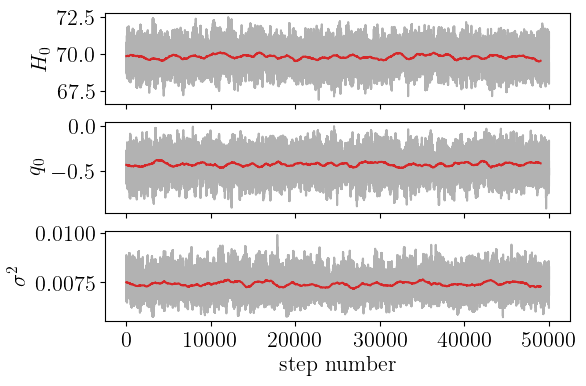

In [157]:
trace_plotter(samples)

### Posterior predictive distribution

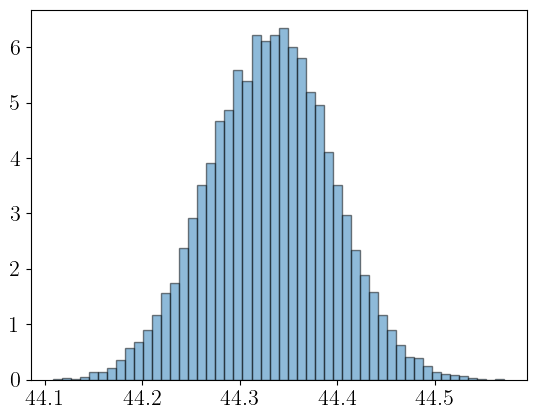

In [158]:
H = samples[:,0]
q = samples[:,1]
sigma = samples[:,2]
z = 1

ppd_hist = low_z_model(H, z, q)

plt.hist(ppd_hist, bins=50, density=True, color='tab:blue', alpha=0.5, edgecolor='black');

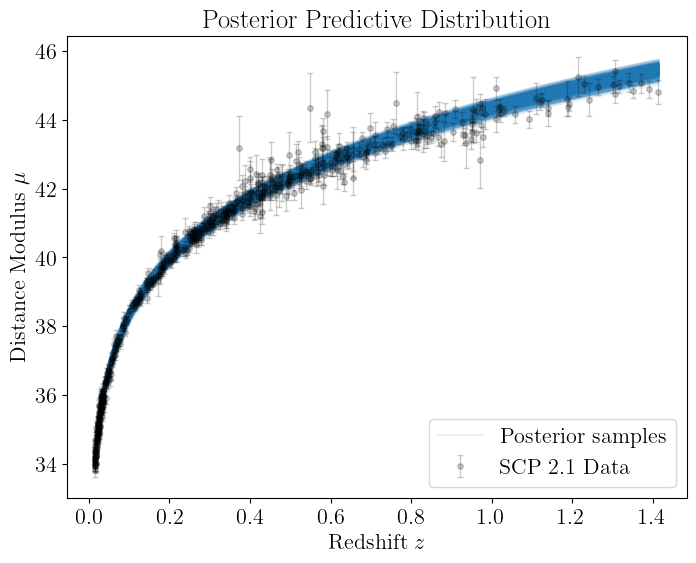

In [ ]:
Nsamp = 500
sample_idx = random.sample(range(0, len(samples)), Nsamp)

z_ = np.linspace(np.min(df['z']), np.max(df['z']), len(df['z']))
plt.figure(figsize=(8,6))

for idx in sample_idx:
    H_i = samples[idx,0]
    q_i = samples[idx,1]
    mu_hat = low_z_model(H_i, z_, q_i) + np.random.normal(0,np.sqrt(samples[idx,2]))
    lbl = 'Posterior samples' if idx == sample_idx[0] else None
    plt.plot(z_, mu_hat, color='tab:blue', alpha=0.1, label=lbl)

plt.xlabel('Redshift $z$')
plt.ylabel('Distance Modulus $\\mu$')
plt.title('Posterior Predictive Distribution')
plt.errorbar(df['z'], df['mu'], yerr=mu_err, fmt='o', markersize=4, elinewidth=1, capsize=2, alpha=0.2, label='SCP 2.1 Data', color='black')
plt.legend()
# plt.savefig('figs/ppd_mu_vs_z.pdf')

### Check extraction of H0 in the low-z limit

In [ ]:
# Check extraction of H0 in the low-z limit
H0_extracted = np.mean(H)
print(f'Extracted H0: {H0_extracted} km/s/Mpc')

i = df['z'] < 0.05
z_very_low = np.array(df['z'][i])
mu_very_low = np.array(df['mu'][i])
mu_err_very_low = np.array(df['mu_err'][i])

# Luminosity distance in the very low-z limit
dl = 10**((mu_very_low - 25.0)/5.0)
sigma_dl = (np.log(10)/5.0) * dl * mu_err_very_low

def wls(z,d,sigma):
    # dl = (c / H0) * z => dl = k * z, with k = c / H0
    # weighted least squares slope through origin
    w = 1 / sigma**2  # weights = 1/variance
    wls_cov   = 1/np.sum(w * z**2)
    wls_xTd   = np.sum(w * z * d)
    wls_theta = wls_cov * wls_xTd
    return wls_theta

theta_hat = wls(z_very_low, dl, sigma_dl)
H0_hat = c / theta_hat

dl_wls = theta_hat*np.sort(z_very_low)
dl_bayes = c/H0_extracted*np.sort(z_very_low)

plt.figure(figsize=(7,5))
plt.errorbar(np.sort(z_very_low), np.sort(dl), yerr=np.sort(sigma_dl), fmt='o', markersize=4, elinewidth=1, capsize=2, alpha=0.1, label='SCP 2.1 Data', color='black')
plt.plot(np.sort(z_very_low), dl_wls, label=f'WLS Fit: $H_0$ = {H0_hat:.2f} km/s/Mpc')
plt.plot(np.sort(z_very_low), dl_bayes, label=f'Bayes Fit: $H_0$ = {H0_extracted:.2f} km/s/Mpc')
plt.xlabel('$z$')
plt.ylabel(r'$d_L$ [Mpc]')
plt.title('Linear Luminosity Distance Fit')
plt.legend()
plt.tight_layout()
# plt.savefig('figs/low_z_luminosity_distance_fit.pdf')


## Model comparison in full $z$-regime

### Defining the model

In [160]:
z = np.array(df['z'])
mu = np.array(df['mu'])
mu_err = np.array(df['mu_err'])

In [161]:
def E(theta, z):
    try:
        Om_M = theta[0]
        w = theta[1]
    except:
        Om_M = theta
        w = -1

    Om_lam = 1 - Om_M  # assuming flat universe Om_k=0
    
    return Om_M *(1 + z)**3 + Om_lam * (1 + z)**(3 * (1 + w))


def model(theta, z, H0 = 70):
    d = np.zeros_like(z)
    for i, z_i in enumerate(z):
        z_p = np.linspace(0, z_i, 50)
        d[i] = c * (1 + z_i) * np.trapezoid(y=1/ (H0 * np.sqrt(E(theta, z_p))), x=z_p)

    mu = d_to_mu(d)
    return mu

### Defining distributions and evaluation functions

In [ ]:
def log_likelihood2(theta, z, mu, sig_mu):
       Nd = len(mu)
       resid = mu - model(theta, z)
       W = 1.0 / (sig_mu**2)
       quad = -1/2 * np.sum(resid**2 * W)
       const = -Nd/2 * np.log(2 * np.pi) + 1/2 * np.sum(np.log(W))
       return quad + const

# Fix value for w = -1 (LambdaCDM)
def log_prior_OmM(Om_M):
    log_pdf = uniform.logpdf(Om_M, 0, 1)
    return log_pdf

def log_posterior_OmM(theta, z, mu, mu_err):
    Om_M = theta[0]     # fix w = -1
    lp = log_prior_OmM(Om_M)
    ll = log_likelihood2([Om_M, -1], z, mu, mu_err)
    return lp + ll

def ml_param(theta0, z=df['z'], mu=df['mu'], dmu=df['mu_err']):
    res = scipy.optimize.minimize(lambda th: -log_likelihood2(th, z, mu, dmu), theta0)
    theta_opt = res.x
    return theta_opt

def bic(theta, z, mu, mu_err):
    Np = len(theta)
    Nd = len(mu)
    return 2 * log_likelihood2(theta, z, mu, mu_err) - Np * np.log(Nd)

def aic(theta, z, mu, mu_err):
    Np = len(theta)
    return 2 * log_likelihood2(theta, z, mu, mu_err) - 2 * Np

### Maximum likelihood

In [163]:
th_opt_lam = ml_param(theta0=[1, -1])
th_opt_w = ml_param(theta0=1)

print('theta opt M:', th_opt_lam)
print('theta opt w:', th_opt_w)

theta opt M: [ 0.27965822 -1.0045319 ]
theta opt w: [0.27771576]


In [164]:
grid = 50
Om_M_grid = np.linspace(0,0.5,grid)
w_grid = np.linspace(0,-1.5,grid)

Om_M_g, w_g = np.meshgrid(Om_M_grid,w_grid)

n = 0
like = np.zeros((len(w_grid),len(Om_M_grid)))
sum_like = 0
for w_i,i in zip(w_grid, range(len(w_grid))):
    for Om_M_i,j in zip(Om_M_grid, range(len(Om_M_grid))):
        lh = log_likelihood2([Om_M_i, w_i], z, mu, mu_err)
        like[i,j] = np.exp(lh)

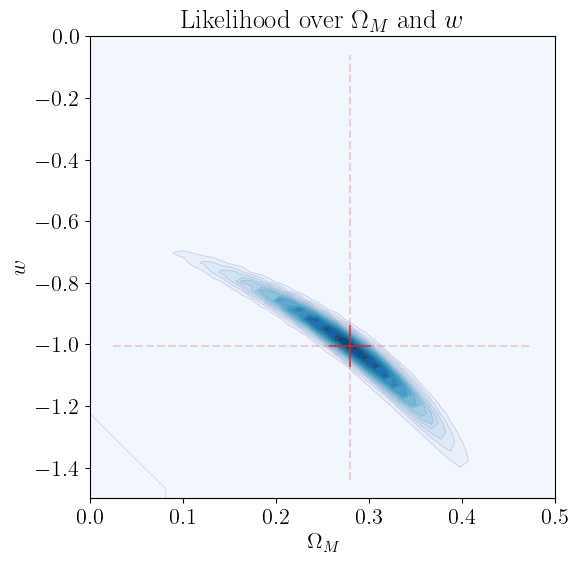

In [165]:
x_opt = th_opt_lam[0]   # Omega_m from lambdaCDM
y_opt = th_opt_lam[1]         # w

xmin, xmax = np.min(Om_M_g)+0.05*np.max(Om_M_g), np.max(Om_M_g)-0.05*np.max(Om_M_g)
ymin, ymax = np.min(w_g)+0.04*np.max(np.abs(w_g)), np.max(w_g)-0.04*np.max(np.abs(w_g))

dx = 0.05 * (xmax - xmin)
dy = 0.05 * (ymax - ymin)

level = 20

plt.figure(figsize=(6,6))
plt.contour(Om_M_g, w_g, like, levels=level, alpha=0.2, linewidths=0.5)
plt.contourf(Om_M_g, w_g, like, levels=level, cmap='Blues')
# full crosshair (dashed)
plt.vlines(x_opt, ymin=ymin, ymax=ymax, colors='tab:red', linestyles='--', lw=1.5, alpha=0.2)
plt.hlines(y_opt, xmin=xmin, xmax=xmax, colors='tab:red', linestyles='--', lw=1.5, alpha=0.2)

# short tick at the intersection (solid)
plt.vlines(x_opt, ymin=y_opt-dy, ymax=y_opt+dy, colors='tab:red', lw=1.5, alpha=0.7)
plt.hlines(y_opt, xmin=x_opt-dx, xmax=x_opt+dx, colors='tab:red', 
           lw=1.5, alpha=0.7)

plt.xlabel(r'$\Omega_M$')
plt.ylabel(r'$w$')
plt.title('Likelihood over $\\Omega_M$ and $w$')
# plt.legend()
# plt.tight_layout()
# plt.savefig('figs/w_vs_Om_m_1.pdf')

### Model comparison with maximum lielihood estimator

In [178]:
th_opt_w = ml_param(theta0=[1, -1])
print('--- wCDM ---')
print(f'Optimal parameters Om_M, w: {th_opt_w}')
print(f'Optimal parameters Om_lam: {1-th_opt_w[0]}')
print(f'BIC: {bic(th_opt_w, z, mu, mu_err)}')
print(f'AIC: {aic(th_opt_w, z, mu, mu_err)}')

th_opt_lam = ml_param(theta0=1)
print('--- LambdaCDM---')
print(f'Optimal parameters: {th_opt_lam}')
print(f'Optimal parameters Om_lam: {1-th_opt_lam[0]}')
print(f'BIC: {bic([th_opt_lam[0], -1], z, mu, mu_err)}')
print(f'AIC: {aic([th_opt_lam[0], -1], z, mu, mu_err)}')

--- wCDM ---
Optimal parameters Om_M, w: [ 0.27965822 -1.0045319 ]
Optimal parameters Om_lam: 0.7203417762300268
BIC: 224.75546850797429
AIC: 233.48152471505523
--- LambdaCDM---
Optimal parameters: [0.27771576]
Optimal parameters Om_lam: 0.7222842434080371
BIC: 224.7545027535494
AIC: 233.48055896063033
BIC: 224.7545027535494
AIC: 233.48055896063033


<>:2: SyntaxWarning: invalid escape sequence '\L'
<>:2: SyntaxWarning: invalid escape sequence '\L'
/var/folders/cc/g7htxfj57sq65d7g1185yzwr0000gn/T/ipykernel_47983/803571592.py:2: SyntaxWarning: invalid escape sequence '\L'
  plt.plot(np.sort(z), model(th_opt_lam, np.sort(z)), color='tab:red', label='Model Prediction: $\Lambda$CDM')


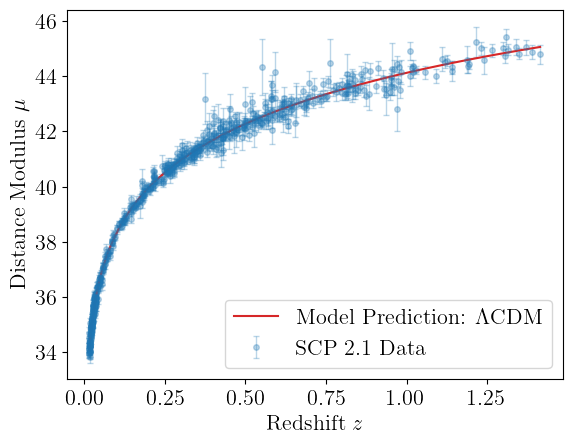

In [179]:
plt.errorbar(z, mu, yerr=mu_err, fmt='o', markersize=4, elinewidth=1, capsize=2, alpha=0.3, label='SCP 2.1 Data', color='tab:blue')
plt.plot(np.sort(z), model(th_opt_lam, np.sort(z)), color='tab:red', label='Model Prediction: $\Lambda$CDM')
plt.xlabel('Redshift $z$');
plt.ylabel('Distance Modulus $\\mu$')
plt.legend()

### Posterior probability for $\Omega_{M,0}$ using $\Lambda\text{CDM}$

#### MCMC sampling the posterior

In [182]:
def samples_MCMC2(theta_lims, function, x, y, sigma, nwalkers, iterations=10000, burninproc=0.10):
    """
    Run emcee for arbitrary parameter vector theta.

    Parameters
    ----------
    theta_lims : list[(low, high)]
        Bounds for each parameter (ndim = len(theta_lims)).
    function : callable
        Log-prob function: function(theta, x, y, sigma) -> logp (float).
    x, y : array-like
        Data.
    sigma : float or array-like
        Known observational uncertainties (as used by `function`).
    nwalkers : int
        Number of walkers (≥ 2*ndim recommended).
    iterations : int, optional
        Number of production steps (after burn-in). Default 10000.
    burnin_frac : float, optional
        Fraction of `iterations` used as burn-in. Default 0.10.
    seed : int, optional
        RNG seed. Default 1337.

    Returns
    -------
    samples : (N, ndim) ndarray
        Flattened chain from production run.
    sampler : emcee.EnsembleSampler
        The sampler (for diagnostics).
    """

    # --- setup
    theta_lims = np.asarray(theta_lims, dtype=float)
    ndim = theta_lims.shape[0]
    rng = np.random.default_rng(1337)

    # --- initialize walkers uniformly within the bounds
    lows  = theta_lims[:, 0]
    highs = theta_lims[:, 1]
    p0 = rng.uniform(lows, highs, size=(nwalkers, ndim))

    # --- burn-in
    burnin = max(1, int(burninproc * iterations))
    sampler = emcee.EnsembleSampler(nwalkers, ndim, function, args=(x, y, sigma))
    p_burn, _, _ = sampler.run_mcmc(p0, burnin, progress=False) # position after burnin

    # --- production
    sampler.reset()
    sampler.run_mcmc(p_burn, iterations, progress=True)
    samples = sampler.get_chain(flat=True)

    return samples

In [183]:
Om_M_lims = [(0.1,0.4)]
x = z
y = mu
sigma = mu_err

samples = samples_MCMC2(Om_M_lims, log_posterior_OmM, x, y, sigma, 
                        nwalkers=10, iterations=int(1e3))

100%|██████████| 1000/1000 [01:45<00:00,  9.49it/s]


#### Plotting posterior

Ω_m = 0.2779 (+0.0129, -0.0133)


<>:16: SyntaxWarning: invalid escape sequence '\O'
<>:16: SyntaxWarning: invalid escape sequence '\O'
/var/folders/cc/g7htxfj57sq65d7g1185yzwr0000gn/T/ipykernel_47983/3158673138.py:16: SyntaxWarning: invalid escape sequence '\O'
  plt.title('Posterior Distribution for $\Omega_M$ (w = -1)')


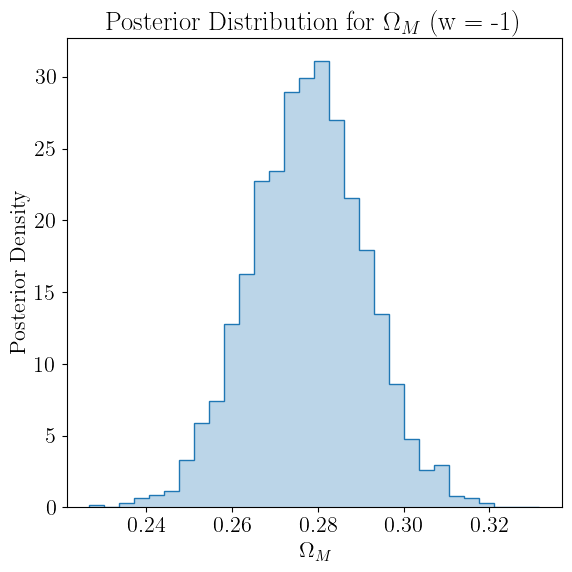

In [187]:
# compute the percentiles (16th, 50th, 84th)
q16, q50, q84 = np.percentile(samples, [16, 50, 84])
err_low  = q50 - q16
err_high = q84 - q50

print(f"Ω_m = {q50:.4f} (+{err_high:.4f}, -{err_low:.4f})")

plt.figure(figsize=(6,6))
plt.hist(samples, bins=30, density=True,
         alpha=0.3, color='tab:blue')
plt.hist(samples, bins=30, density=True,
         histtype='step', color='tab:blue', linewidth=1)

plt.xlabel(r'$\Omega_M$')
plt.ylabel('Posterior Density')
plt.title('Posterior Distribution for $\Omega_M$ (w = -1)')
plt.tight_layout()
# plt.savefig('figs/Om_m_posterior.pdf')
